In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from community import community_louvain

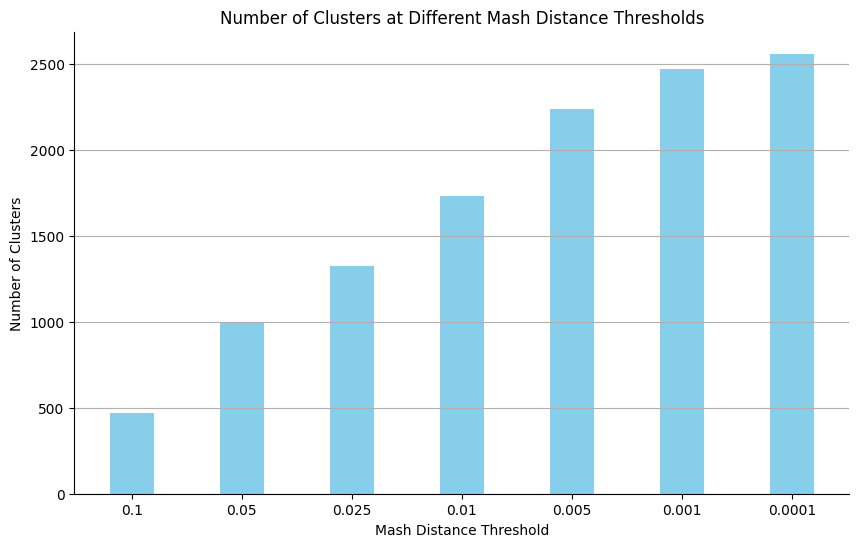

In [2]:
def louvain_cluster_count(df, threshold):
    G = nx.Graph()
    for i in df.index:
        for j in df.columns:
            if df.at[i, j] <= threshold:
                G.add_edge(i, j)
    communities = community_louvain.best_partition(G)
    return len(set(communities.values()))

# Load your Mash distance matrix
df = pd.read_csv('/Users/annasve/Desktop/data/ncbi_genomes/analysis/mash/mash_distance_matrix.csv', index_col=0)

# Thresholds to test
thresholds = [0.1, 0.05, 0.025, 0.01, 0.005, 0.001, 0.0001]
cluster_counts = []

for threshold in thresholds:
    cluster_count = louvain_cluster_count(df, threshold)
    cluster_counts.append(cluster_count)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(thresholds)), cluster_counts, width=0.4, color='skyblue', align='center')
plt.xlabel('Mash Distance Threshold')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters at Different Mash Distance Thresholds')
plt.xticks(range(len(thresholds)), labels=thresholds)
plt.grid(axis='y', which='both')

# Good data visualization principles
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


In [3]:
# Specify the threshold for the produced csv
threshold = 0.001

In [4]:
def find_representatives(df, threshold):
    # Create the graph
    G = nx.Graph()
    for i in df.index:
        for j in df.columns:
            if df.at[i, j] <= threshold:
                G.add_edge(i, j)

    # Apply the Louvain community detection algorithm
    communities = community_louvain.best_partition(G)

    # Invert the partition for easier processing
    clusters = {}
    for genome, cluster in communities.items():
        clusters.setdefault(cluster, []).append(genome)

    # Find the representative for each cluster
    representatives = {}
    for cluster, genomes in clusters.items():
        if len(genomes) == 1:
            # If the cluster has only one genome, it is the representative
            representatives[cluster] = genomes[0]
        else:
            # Find the genome with the smallest average distance to others in the cluster
            min_avg_distance = float('inf')
            representative = None
            for genome in genomes:
                avg_distance = df.loc[genome, genomes].mean()
                if avg_distance < min_avg_distance:
                    min_avg_distance = avg_distance
                    representative = genome
            representatives[cluster] = representative

    return representatives

# Get the representatives for the specified threshold
representatives = find_representatives(df, threshold)

print(f"Representatives for threshold {threshold}:")
for cluster, representative in representatives.items():
    print(f"Cluster {cluster}: Representative Genome - {representative}")

Representatives for threshold 0.001:
Cluster 0: Representative Genome - GCF_000009765.2
Cluster 1: Representative Genome - GCF_000009805.1
Cluster 2: Representative Genome - GCF_000010105.1
Cluster 3: Representative Genome - GCF_000010605.1
Cluster 4: Representative Genome - GCF_000024345.1
Cluster 6: Representative Genome - GCF_039544695.1
Cluster 9: Representative Genome - GCF_016859185.1
Cluster 12: Representative Genome - GCF_000091305.1
Cluster 13: Representative Genome - GCF_000145235.1
Cluster 14: Representative Genome - GCF_000148465.1
Cluster 17: Representative Genome - GCF_005519465.1
Cluster 19: Representative Genome - GCF_000177195.2
Cluster 20: Representative Genome - GCF_000177655.2
Cluster 21: Representative Genome - GCF_000196675.2
Cluster 24: Representative Genome - GCF_000282715.1
Cluster 26: Representative Genome - GCF_000213055.1
Cluster 27: Representative Genome - GCF_000220705.2
Cluster 29: Representative Genome - GCF_000236965.1
Cluster 30: Representative Genome 

In [5]:
# Assuming 'representatives' is your dictionary from the previous script
representative_genomes = list(representatives.values())

# Create a DataFrame
df_representatives = pd.DataFrame(representative_genomes, columns=['genome_id'])

# Save to CSV
df_representatives.to_csv('/Users/annasve/Desktop/data/ncbi_genomes/analysis/mash/representative_genomes_0.001.csv', index=False)

## Here we want to create a master dataframe for the dataset of all different thresholds

In [6]:
def assign_clusters_and_representatives(df, threshold):
    G = nx.Graph()
    for i in df.index:
        for j in df.columns:
            if df.at[i, j] <= threshold:
                G.add_edge(i, j)
    communities = community_louvain.best_partition(G)

    # Map genomes to clusters and find representatives
    genome_to_cluster = {}
    cluster_to_representative = {}
    for genome, cluster in communities.items():
        genome_to_cluster[genome] = cluster
        cluster_to_representative.setdefault(cluster, []).append(genome)

    # Determine representative for each cluster
    for cluster, genomes in cluster_to_representative.items():
        if len(genomes) == 1:
            cluster_to_representative[cluster] = genomes[0]
        else:
            representative = min(genomes, key=lambda g: df.loc[g, genomes].mean())
            cluster_to_representative[cluster] = representative

    return genome_to_cluster, cluster_to_representative

# Thresholds to test
thresholds = [0.1, 0.05, 0.025, 0.01, 0.005, 0.001, 0.0001]

# Initialize DataFrame for final table
final_table = pd.DataFrame(index=df.index)

# Populate the DataFrame
for threshold in thresholds:
    genome_to_cluster, cluster_to_representative = assign_clusters_and_representatives(df, threshold)
    final_table[f'Cluster_{threshold}'] = final_table.index.map(genome_to_cluster)
    final_table[f'Representative_{threshold}'] = final_table[f'Cluster_{threshold}'].map(cluster_to_representative)

# Save to CSV
final_table.to_csv('/Users/annasve/Desktop/data/ncbi_genomes/analysis/mash/mash_clusters_and_representatives_0.001.csv')

print("Mash clusters and representatives table saved.")


Mash clusters and representatives table saved.
